# Import libraries

In [1]:
import torch.nn as nn
import matplotlib.pyplot as plt 
import copy 
import random
import sys
import numpy as np 
import pandas as pd
import torch
from sklearn.preprocessing import MinMaxScaler 

# Load dataset

In [2]:
olist_orders = pd.read_csv("/Users/phuongnguyen/Documents/Code Github/mlops-ml-ecommerce-customers/sample_files/olist_dataset/olist_orders_dataset.csv")

In [3]:
### Extract monthly sales
# Convert order purchase timestamp to_datetime
olist_orders['purchase_datetime'] = pd.to_datetime(olist_orders['order_purchase_timestamp'])
# Get date only
olist_orders['purchase_date'] = olist_orders['purchase_datetime'].dt.date
# Get month only
olist_orders['purchase_month'] = olist_orders['purchase_datetime'].dt.strftime('%Y-%m')

olist_orders.head(5)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,purchase_datetime,purchase_date,purchase_month
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,2017-10-02 10:56:33,2017-10-02,2017-10
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,2018-07-24 20:41:37,2018-07-24,2018-07
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,2018-08-08 08:38:49,2018-08-08,2018-08
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,2017-11-18 19:28:06,2017-11-18,2017-11
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,2018-02-13 21:18:39,2018-02-13,2018-02


In [4]:
#Group by month, number of orders
orders_bymonth = olist_orders.groupby('purchase_month')['order_id'].nunique().reset_index()
orders_bymonth.columns = ['month', 'no_orders']
#Sort ascending month
orders_bymonth = orders_bymonth.sort_values('month', ascending = False)
orders_bymonth.head(5)

,month,no_orders
24,2018-10,4
23,2018-09,16
22,2018-08,6512
21,2018-07,6292
20,2018-06,6167


In [5]:
#Group by date, number of orders
orders_bydate = olist_orders.groupby('purchase_date')['order_id'].nunique().reset_index()
orders_bydate.columns = ['date', 'no_orders']
orders_bydate = orders_bydate.sort_values('date', ascending = False)
orders_bydate.head(5)

,date,no_orders
633,2018-10-17,1
632,2018-10-16,1
631,2018-10-03,1
630,2018-10-01,1
629,2018-09-29,1


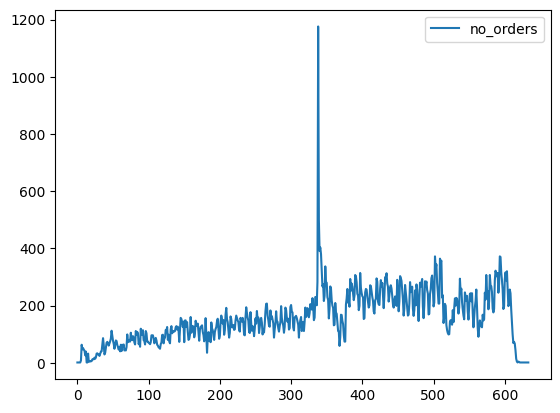

In [6]:
orders_bydate.plot()
plt.show()

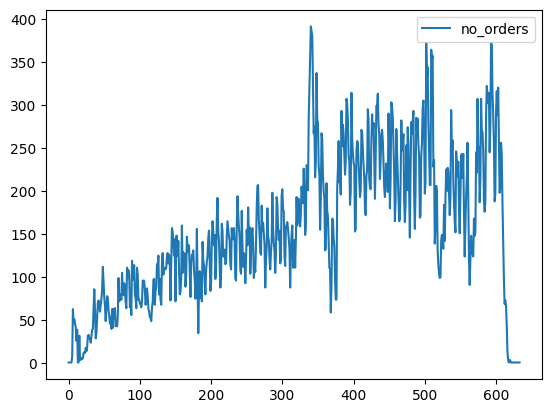

In [7]:
# Remove outliers
orders_bydate_filtered = orders_bydate.loc[orders_bydate['no_orders'] < 400]

orders_bydate_filtered.plot()
plt.show()


# Preparing datasets for training

In [8]:
orders_bydate_rnn = orders_bydate_filtered.copy()

In [9]:
#set_index by date, make sure sort descending correctly
# orders_bydate_rnn.set_index('date', inplace = True)
# orders_bydate_rnn.head(5)

In [10]:
orders_bydate_rnn.sort_values('date', inplace = True)

In [11]:
orders_bydate_rnn

,date,no_orders
0,2016-09-04,1
1,2016-09-05,1
2,2016-09-13,1
3,2016-09-15,1
4,2016-10-02,1
...,...,...
629,2018-09-29,1
630,2018-10-01,1
631,2018-10-03,1
632,2018-10-16,1


In [12]:
#Normalize time series in range [0,1] 
scaler = MinMaxScaler()
#df_scaled = scaler.fit_transform(orders_bydate_rnn)
orders_bydate_rnn['scaled_orders'] = scaler.fit_transform(orders_bydate_rnn[['no_orders']])

In [13]:
orders_bydate_rnn

,date,no_orders,scaled_orders
0,2016-09-04,1,0.0
1,2016-09-05,1,0.0
2,2016-09-13,1,0.0
3,2016-09-15,1,0.0
4,2016-10-02,1,0.0
...,...,...,...
629,2018-09-29,1,0.0
630,2018-10-01,1,0.0
631,2018-10-03,1,0.0
632,2018-10-16,1,0.0


In [14]:
def create_sequences(data, window_size):
    sequences = []
    labels = []
    for i in range(len(data) - window_size):
        seq = data[i: i + window_size]
        label = data[i+ window_size]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

In [15]:
window_size = 10
data = orders_bydate_rnn['scaled_orders'].values
X, y = create_sequences(data, window_size)

In [16]:
X.shape

(621, 10)

In [17]:
y.shape

(621,)

In [18]:
# Reshape X to (samples, seq_len, 1) for RNN input
X = X.reshape(X.shape[0], X.shape[1], 1)
y = y.reshape(-1, 1)

In [19]:
X.shape

(621, 10, 1)

In [20]:
y.shape

(621, 1)

# Create a custom dataset for class for Pytorch Dataloader

In [21]:
# Split the data into training and test sets
train_size = int(0.7 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [22]:
X_test.shape

(187, 10, 1)

In [23]:
X_test_tensor = torch.tensor(X, dtype = torch.float32)

In [24]:
from torch.utils.data import DataLoader, Dataset
class RNNDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype = torch.float32)
        self.y = torch.tensor(y, dtype = torch.float32)

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]

# Bidirectional LSTM Model

In [25]:
import torch
import torch.nn as nn

In [26]:
class BRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_size, hidden_size, num_layers, batch_first = True, bidirectional=True
        )
        self.fc = nn.Linear(hidden_size *2, num_classes)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size)

        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])

        return out

In [27]:
bilstm = BRNN(input_size = 1, hidden_size = 32, num_layers = 10, num_classes = 10)
bilstm.state_dict()

OrderedDict([('lstm.weight_ih_l0',
              tensor([[-0.0726],
                      [ 0.0275],
                      [-0.0425],
                      [-0.0110],
                      [-0.0878],
                      [ 0.0032],
                      [ 0.0636],
                      [-0.0319],
                      [ 0.0987],
                      [ 0.1207],
                      [-0.1044],
                      [ 0.1768],
                      [ 0.0656],
                      [ 0.0323],
                      [-0.1019],
                      [-0.0287],
                      [ 0.1467],
                      [-0.0223],
                      [-0.0653],
                      [ 0.0843],
                      [ 0.0696],
                      [ 0.1426],
                      [ 0.1127],
                      [ 0.0695],
                      [ 0.0914],
                      [ 0.0057],
                      [-0.1160],
                      [-0.0820],
                      [ 0.1329],
        

In [28]:
# Make predictions with model
with torch.inference_mode(): 
    y_preds = bilstm(X_test_tensor)

In [29]:
y_preds.shape

torch.Size([621, 10])

In [30]:
class RNN(nn.Module):
    def __init__(self, hidden_size, in_size = 1, out_size = 1):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(input_size = in_size,
                            hidden_size = hidden_size,
                            batch_first = True)
        self.fc = nn.Linear(hidden_size, out_size)
    
    def forward(self, x, h = None):
        out, _ = self.rnn(x, h)
        last_hidden_states = out[:, -1]
        out = self.fc(last_hidden_states)
        return out

In [31]:
rnn_model = RNN(hidden_size = 32)
rnn_model.state_dict()

OrderedDict([('rnn.weight_ih_l0',
              tensor([[-0.0963],
                      [-0.0614],
                      [-0.1474],
                      [ 0.0510],
                      [ 0.0532],
                      [ 0.1382],
                      [-0.0456],
                      [ 0.0458],
                      [ 0.0597],
                      [ 0.1561],
                      [-0.0215],
                      [-0.0267],
                      [ 0.0931],
                      [-0.1333],
                      [-0.1148],
                      [-0.0338],
                      [-0.1343],
                      [ 0.1504],
                      [-0.0307],
                      [-0.0696],
                      [-0.1738],
                      [-0.0260],
                      [ 0.0771],
                      [-0.0663],
                      [-0.1606],
                      [ 0.1444],
                      [ 0.0693],
                      [ 0.1534],
                      [-0.0059],
         

In [32]:
# Make predictions with model
with torch.inference_mode(): 
    y_preds = rnn_model(X_test_tensor)

# Hyperparameters

In [33]:
hidden_size = 32
learning_rate = 0.02
training_epochs = 500
batch_size = 64


In [34]:
#Create Data Loaders
train_dataset = RNNDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_dataset = RNNDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [35]:
train_dataset

In [36]:
#Initialize the model, loss function, and optimizer
model = BRNN(input_size = 1, hidden_size = 32, num_layers = 10, num_classes = 10)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training

In [37]:
# 6. Training loop
num_epochs = 100
for epoch in range(num_epochs):
    ###TRAINING

    #Put model in training mode
    model.train()

    train_loss = 0
    #Loop in batch
    for X_batch, y_batch in train_loader:
        #1. Forward pass on train data using the forward() method inside
        y_pred = model(X_batch)

        #2. Calculate the loss (how different are our models predictions to the ground truth)
        loss = criterion(y_pred, y_batch)

        #3. Zero grad of the optimizer
        optimizer.zero_grad()

        #4. Loss backwards
        loss.backward()
        
        #5. Progress the optimizer
        optimizer.step()

        #6. Accumulate loss
        train_loss += loss.item()

    ###TESTING
    model.eval()

    test_loss = 0

    with torch.inference_mode():
        #Create loop in batch
        for X_batch, y_batch in test_loader:
            #1. Forward pass on the test data
            y_pred = model(X_batch)

            #2. Calculate loss on test data
            loss = criterion(y_pred, y_batch)

            #3. Accumulate loss
            test_loss += loss.item()

    if epoch % 10 == 0:
        print(f"Epoch {epoch} - Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")

/Users/phuongnguyen/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/phuongnguyen/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([50, 1])) that is different to the input size (torch.Size([50, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/phuongnguyen/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([59, 1])) that is different to the input size (torch.Size([59, 10])). This will likely lead to incorrect results du

Epoch 0 - Train Loss: 0.5425 | Test Loss: 0.2049
Epoch 10 - Train Loss: 0.2698 | Test Loss: 0.2169
Epoch 20 - Train Loss: 0.2655 | Test Loss: 0.2183
Epoch 30 - Train Loss: 0.2630 | Test Loss: 0.2187
Epoch 40 - Train Loss: 0.2610 | Test Loss: 0.2204
Epoch 50 - Train Loss: 0.2595 | Test Loss: 0.2204
Epoch 60 - Train Loss: 0.2583 | Test Loss: 0.2200
Epoch 70 - Train Loss: 0.2573 | Test Loss: 0.2205
Epoch 80 - Train Loss: 0.2565 | Test Loss: 0.2207
Epoch 90 - Train Loss: 0.2559 | Test Loss: 0.2205


In [38]:
# 7. Predict on test set
model.eval()
with torch.no_grad():
    test_inputs = torch.tensor(X_test, dtype=torch.float32)
    predictions = model(test_inputs).numpy()

# Inverse scale predictions and actuals
y_test_inv = scaler.inverse_transform(y_test)
predictions_inv = scaler.inverse_transform(predictions)

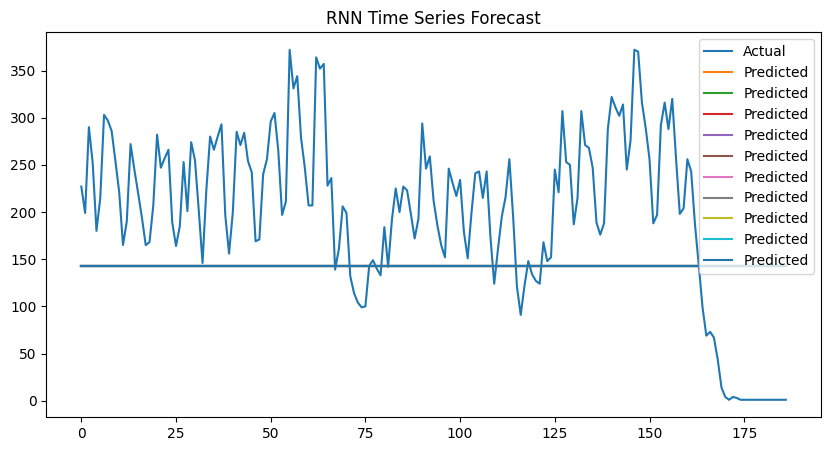

In [39]:
# 8. Plot
plt.figure(figsize=(10,5))
plt.plot(y_test_inv, label='Actual')
plt.plot(predictions_inv, label='Predicted')
plt.legend()
plt.title("Bidirectional LSTM Time Series Forecast")
plt.show()

References:
- My blog: https://open.substack.com/pub/quynhanhphuong/p/gated-recurrent-units-gru?r=1xb8sg&utm_campaign=post&utm_medium=web&showWelcomeOnShare=false
- Book: Dive into Deep Learning
- Chapter 4: Recurrent Neural Networks in book Time series forecasting using Deep Learning